#### load dependencies

In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout,Dense,Flatten
from keras.models import Model
from keras.layers import Input,concatenate
from keras.layers import Embedding
from keras.layers import Conv1D,SpatialDropout1D,GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from keras.datasets import imdb
%matplotlib inline

C:\Users\Munna chowhan\Anaconda3\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### set hyperparameters

In [2]:
output_dir = "model_output/Multi_CNN/"

epochs = 4
batch_size = 128

#embedding layer:
n_dims = 64
max_review_length = 400
n_unique_words = 5000
#while padding if the review is < 100 words pad it at the beginning of the review.
#while truncating if the review is > 100 cut the review at the beginning
pad_type = trunc_type = "pre"
dropout_embed = 0.2
#conv layer:
n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv1 = 3
k_conv2 = 2
k_conv3 = 4

#dense_layer:
n_dense = 256
dropout = 0.2

### load data

In [3]:
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=n_unique_words)

### preprocessing data

In [4]:
x_train = pad_sequences(x_train,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)
x_test = pad_sequences(x_test,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)

### model architecture(Functional API)

In [5]:
input_layer = Input(shape=(max_review_length,),name ="input", dtype="int16")
embedding_layer  =Embedding(n_unique_words,n_dims,input_length=max_review_length, name="embedding")(input_layer)
drop_embed_layer = SpatialDropout1D(dropout_embed, name="embed_dropout")(embedding_layer)

conv_1 = Conv1D(n_conv_1, k_conv1,activation="relu", name="conv_1")(drop_embed_layer)
max_pool_1 =GlobalMaxPooling1D(name="mpool_1")(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv2,activation="relu", name="conv_2")(drop_embed_layer)
max_pool_2 =GlobalMaxPooling1D(name="mpool_2")(conv_2)


conv_3 = Conv1D(n_conv_3, k_conv3,activation="relu", name="conv_3")(drop_embed_layer)
max_pool_3 =GlobalMaxPooling1D(name="mpool_3")(conv_3)

concat = concatenate([max_pool_1,max_pool_2,max_pool_3], name="concat_layer")

dense_1 = Dense(n_dense,activation="relu",name="dense_1")(concat)
dense_drop_1 = Dropout(dropout, name = "Dense_drop_1")(dense_1)

dense_2 = Dense(n_dense,activation="relu",name="dense_2")(dense_drop_1)
dense_drop_2 = Dropout(dropout, name = "Dense_drop_2")(dense_2)



predictions = Dense(1,activation="sigmoid", name ="output")(dense_drop_2)
model = Model(input_layer, predictions)

In [ ]:
model.summary()

In [6]:
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=["accuracy"])

### save the model weights for every epoch

In [7]:
modelcheckpoint  = ModelCheckpoint(filepath=output_dir +"weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### train the model

In [8]:
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test),verbose=1, callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 717s 29ms/step - loss: 0.4964 - acc: 0.7255 - val_loss: 0.2916 - val_acc: 0.8786
Epoch 2/4
25000/25000 [==============================] - 628s 25ms/step - loss: 0.2444 - acc: 0.9023 - val_loss: 0.2767 - val_acc: 0.8858
Epoch 3/4
25000/25000 [==============================] - 628s 25ms/step - loss: 0.1700 - acc: 0.9377 - val_loss: 0.2656 - val_acc: 0.8938
Epoch 4/4
25000/25000 [==============================] - 629s 25ms/step - loss: 0.1236 - acc: 0.9570 - val_loss: 0.3086 - val_acc: 0.8891


### load the epoch with highest validation accuracy

In [9]:
model.load_weights(filepath=output_dir+"/weights.02.hdf5")

### predictions probability on test set

In [12]:
y_pred = model.predict(x_test)

In [13]:
y_pred[0]

array([0.04705636], dtype=float32)

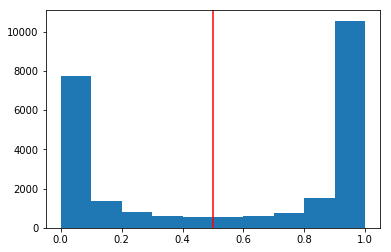

In [14]:
plt.hist(y_pred)
_ = plt.axvline(x = 0.5, color="red")

In [15]:
auc = roc_auc_score(y_test,y_pred)*100.0

In [16]:
auc

96.11724160000001

In [ ]:
predicted_sentiment = []
for i in y_pred:
    predicted_sentiment.append(i[0])

In [ ]:
df = pd.DataFrame(list(zip(predicted_sentiment,y_test)),columns=["predicted","real"])

In [ ]:
df.head()